# Uncorking the I/O Bottleneck of Bio-Imaging

## Part 3 - Analysis of Whole Slide Image Nuclei

Now that we have reduced the dimensionality of our Whole Slide image data to a more manageable size we can load up the features that were saved as a Pandas dataframe in the previous notebook and take a look at a few of the methods that are suitable for this type of data. Rather than using the standard Pandas dataframe, we are going to use the RAPIDS equivalent, cuDF (CUDA dataframe). This loads the data into GPU memory rather than using the host system's RAM. As you will see, this opens up a new realm of possibilities because of the huge speed boost this can provide.

As usual, we start by importing the libraries that we'll need. As you will notice, there are a few new names here, such as cuDF, cuGraph and cuML. These are the core of the RAPIDS tools offering GPU accelerated Dataframe functionality, GPU accelerated graph analytics and GPU accelerated Machine Learning routines

You will find documentation on all of these libraries and features here https://docs.rapids.ai/api

In [1]:
from cuml import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from cuml.neighbors import NearestNeighbors
import cuxfilter
from cuxfilter import DataFrame, layouts
import seaborn as sns
import pandas as pd
import cudf
from cudf import DataFrame
import cugraph
import cuml
import numpy as np

We start by loading the wsi_dfx file, which is a dataframe containing all of the features from the tiles from the last Notebook. Once we have loaded this, you can see that we immediately create a cdDF version of the dataframe, which puts it on to the GPU. The cdf.head command loads the first few rows and you can see that we have the nucleus types and row and column (coordinates).

In [3]:
# import the data we saved in our other notebook
df = pd.read_pickle('/datasets/wsi/centroids.pkl')

#create a cuda dataframe (GPU) from the pandas dataframe (CPU)
cdf = cudf.from_pandas(df)

cdf.head

<bound method Frame.head of           row    col  type
0       48447  50965     1
1       48448  50955     1
2       48475  50935     1
3       48847  50864     4
4       48783  50676     2
...       ...    ...   ...
709214  17765   3244     1
709215  17963   3243     1
709216  17018   3242     2
709217  17349   3240     2
709218  16834   3239     2

[709219 rows x 3 columns]>

We can also display some summary statistics for the dataframe columns

In [ ]:
# get some stats on the data
cdf.describe()

To get a view of the data we can use MatplotLib to show us a scatter-plot using the x and y coordinates of the nuclei, using the type to set the colour of each point in the output. As you can see, this provides a clear indication of the distribution of the various types of nuclei across the tissue.

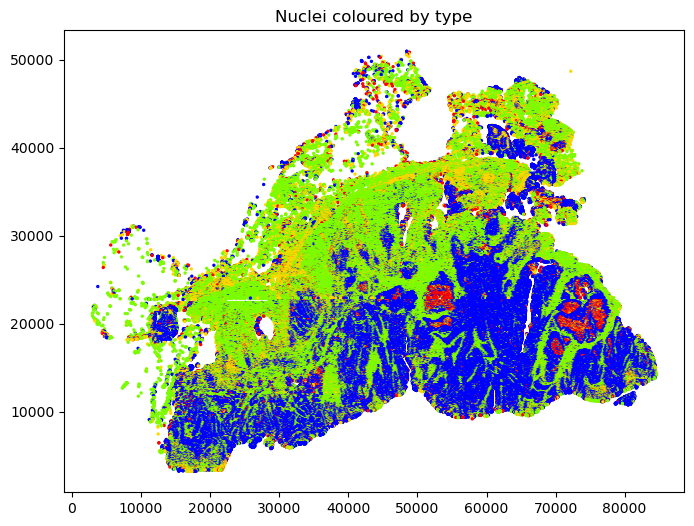

In [5]:
# create a matplotlib colormap to match the previous notebook
cmap = ListedColormap(["blue", "gold", "lawngreen", "red"])

fig, ax = plt.subplots(1, figsize = (8, 6))
plt.scatter(df['row'], df['col'], s = 2, c = df['type'], cmap = cmap)

plt.title('Nuclei coloured by type')
plt.show()

This is certainly an interesting visualisation in its own right, but it doesn't tell us much about the relationships between the cells at a more granular level.

So, what we are going to do now is to create a graph of all the nuclei that we detected and classified in the last notebook. 
In order to construct the graph we are going to use the nearest neighbout algorithm to find the 5 nearest neighbours to each nucleus.

To do this we will need to import some classes from cuNN (A CUDA library for nearest neighbour computation) that is part of the RAPIDS family. 

In [76]:
from cuml.neighbors import NearestNeighbors

knn_cuml = NearestNeighbors()
knn_cuml.fit(cdf)

%time D_cuml, I_cuml = knn_cuml.kneighbors(cdf, 5)
I_cuml, D_cuml

CPU times: user 406 ms, sys: 17.7 ms, total: 424 ms
Wall time: 422 ms


(             0       1       2       3       4
 0            0       1       2       5       6
 1            1       0       2       5       6
 2            2       1       0       5       6
 3            3       4       2       6       5
 4            4       3       6       5      10
 ...        ...     ...     ...     ...     ...
 709214  709214  709207  709204  709199  709187
 709215  709215  709185  709206  709150  709164
 709216  709216  709191  709202  709200  709143
 709217  709217  709209  709210  709205  709182
 709218  709218  709193  709184  709195  709190
 
 [709219 rows x 5 columns],
           0           1           2           3           4
 0       0.0   10.049875   41.036568  325.213776  385.172699
 1       0.0   10.049875   33.600594  315.196777  375.293213
 2       0.0   33.600594   41.036568  291.547607  349.070190
 3       0.0  198.605133  378.726807  397.756195  406.120667
 4       0.0  198.605133  242.911499  279.724854  333.150116
 ...     ...         ...    

So, what this has produced is a list of the 5 nearest neighbours for each nucleus - using the row and col values, which relate to the position of the centroid of each nucleus in pixel space. The KNN (k-nearest neighbours) algorithm is using a Euclidean distance calculation (other algorithms can be used) which tells us how close each node is to every other node. Because we chose 5 as the number of nearest neighbours, we have a row value which represents the index of each node and then five columns containing the indexes of the 5 nearest nodes, with the nearest in column 0 and the furthest in column 4. You will also notice that the index in the nearest column, 0, always matches the row index. That's because the algorithm does not exclude each node from being its own nearest neighbour. We can ignore that column.

We are looking at the indexes in the I_cuml dataframe. To look at the physical distances, in pixels, you should look at the D_cuml dataframe.

If you want to compare this with the sklearn CPU implementation, be aware that it can take > 30 minutes to run! It is not necessary to execute it - the code is there as a reference. 

In [ ]:
# Only run this and the following cell to compare with CPU version
from sklearn.neighbors import NearestNeighbors as skNN

df_1=df[cdf]
knn_sk = skNN(algorithm='brute',n_jobs=1)
knn_sk.fit(df_1)

# Only uncomment the lines below if you have a spare 30 mins to wait for it to complete!
#%time D_sk, I_sk = knn_sk.kneighbors(df_1, 5)
#I_sk

In order to convert the output of the KNN operation into a graph, we need to prepare the data. The data needs to be presented to the RAPIDS graph library, cugraph, as a set of edges with the source and destination node and an optional weight parameter.

Firstly we combine the nearest neighbour indexes and distances into one dataframe and give them unique column names. We do this so that we can use the distance to set the weight of the connection between the nodes

In [77]:
# give the columns names because they have to be unique in the merged dataframe
# Indexes of neighbours
I_cuml.columns=['ix1','n1','n2','n3','n4'] 
# Distance to neighbours
D_cuml.columns=['ix2','d1','d2','d3','d4'] 
# Concatenate the columsn into a single dataframe
all_cols = cudf.concat([I_cuml, D_cuml],axis=1)

# remove the index and distance from the self-referenced nearest neighbour
all_cols = all_cols[['n1','n2','n3','n4','d1','d2','d3','d4']]

all_cols 

n1      n2      n3      n4          d1          d2          d3  \
0            1       2       5       6   10.049875   41.036568  325.213776   
1            0       2       5       6   10.049875   33.600594  315.196777   
2            1       0       5       6   33.600594   41.036568  291.547607   
3            4       2       6       5  198.605133  378.726807  397.756195   
4            3       6       5      10  198.605133  242.911499  279.724854   
...        ...     ...     ...     ...         ...         ...         ...   
709214  709207  709204  709199  709187   19.416489   33.015148   36.359318   
709215  709185  709206  709150  709164   43.611923   55.063599   84.380089   
709216  709191  709202  709200  709143   31.320919   66.738297   72.117958   
709217  709209  709210  709205  709182   20.615528   28.301943   44.294468   
709218  709193  709184  709195  709190   33.241539   47.444706   53.851646   

                d4  
0       385.172699  
1       375.293213  
2       349.070190  
3       406.120667  
4       333.150116  
...            ...  
709214   46.711884  
709215   89.297256  
709216   79.906197  
709217   89.699501  
709218   64.140472  

[709219 rows x 8 columns]

So the next step is to manipulate this data so that it is in the desired format. There should be 3 columns, named 'source', 'target' and 'distance'.

To do this, you will need to extract 4 sets of columns - one for each neighbour - and then concatenate the rows into a new dataframe.

Remember that each row index represents a node, the n1-n4 columns contain the row index of a destination node and the d1-d4 columns contain the distance between these nodes. 

In [78]:
# Reformat the data to match the way edges are defined in cuGraph
all_cols['index1'] = all_cols.index

c1 = all_cols[['index1','n1','d1']]
c1.columns=['source','target','distance']
c2 = all_cols[['index1','n2','d2']]
c2.columns=['source','target','distance']
c3 = all_cols[['index1','n3','d3']]
c3.columns=['source','target','distance']
c4 = all_cols[['index1','n4','d4']]
c4.columns=['source','target','distance']
                 
edges = [c1,c2,c3,c4]

edge_df = cudf.concat(edges)

# remove the old dataframe from memory
del(all_cols)

edge_df = edge_df.reset_index()
edge_df = edge_df[['source','target','distance']]
edge_df

source  target    distance
0             0       1   10.049875
1             1       0   10.049875
2             2       1   33.600594
3             3       4  198.605133
4             4       3  198.605133
...         ...     ...         ...
2836871  709214  709187   46.711884
2836872  709215  709164   89.297256
2836873  709216  709143   79.906197
2836874  709217  709182   89.699501
2836875  709218  709190   64.140472

[2836876 rows x 3 columns]

Next, we need to set a maximum distance between connected nodes, so that we exclude any connections beyond a certain threshold. This may reveal groups of cells that are locally connected but separate from other 'cliques'. We will use a distance of 40 pixels to start off with but you can experiment with this setting.
Note that the distance calculation actually the distance squared (to save many expensive sqrt operations) - so we need to sqaure the threshold too.

In [79]:
edge_df = edge_df.loc[edge_df["distance"] < 40]
edge_df

source  target   distance
0             0       1  10.049875
1             1       0  10.049875
2             2       1  33.600594
11           11      12   6.082763
12           12      11   6.082763
...         ...     ...        ...
2836853  709196  709195  36.000000
2836854  709197  709169  31.032242
2836856  709199  709213  36.359318
2836857  709200  709169  34.942810
2836864  709207  709199  39.736633

[1899647 rows x 3 columns]

This dataframe is now ready to be used to generate the graph. For this we use the cugraph library

In [80]:
# now we can actually create a graph!!
G = cugraph.Graph()

%time G.from_cudf_edgelist(edge_df,source='source', destination='target', edge_attr='distance', renumber=True)

CPU times: user 39.1 ms, sys: 29.3 ms, total: 68.4 ms
Wall time: 65.9 ms


Once we have the graph we can do standard graph analytical operations. Triangle Count is the number of cycles of length three. A k-core of a graph is a maximal subgraph that contains nodes of degree k or more. 

In [81]:
#now we can compute some graph metrics
count = cugraph.triangle_count(G)
print("No of triangles = " + str(count))

coreno = cugraph.core_number(G)
print("Core Number = " + str(coreno))

No of triangles =         counts  vertex
0            8  175364
1            7  175372
2            9  175373
3            8  175388
4            7  175396
...        ...     ...
657044       0  677155
657045       0  677169
657046       0  677181
657047       0  677152
657048       0  677106

[657049 rows x 2 columns]
Core Number =         core_number  vertex
0                 3   14883
1                 3   14897
2                 2   14906
3                 3   14916
4                 4   14936
...             ...     ...
657044            1  677155
657045            1  677169
657046            1  677181
657047            1  677152
657048            1  677106

[657049 rows x 2 columns]


**Visualising the graph**

One powerful feature enabled by the RAPIDS API is the visualisation of large networks. To show this in action we are going to create a chart that displays all the nuclei centroids along with the edges between their nearest neighbours.

To do this we need two dataframes: One containing the nodes and their coordinates and the other with the edges and their source and target nodes

In [ ]:
# we only need the index of the source and target nodes

# The indexes of the source and target nodes that form an edge
edge_df = edge_df[['source','target']]

# The x and y coordinates of each node (nucleus)
nodes_ = cdf[['row','col']]
# Vertex refers to the index of an item in the 
nodes_['vertex']=nodes_.index
nodes_.columns=['x','y','vertex']

Finally we use cuXFilter to render the whole graph!

Card(sizing_mode='scale_width', title='Graph', width=800)
    [0] HoloViews(DynamicMap, height=400, sizing_mode='stretch_both')
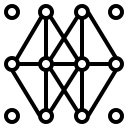
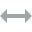

In [10]:
cux_df = cuxfilter.DataFrame.load_graph((nodes_, edge_df))

chart0 = cuxfilter.charts.graph(edge_color_palette=['gray', 'black'],
                                            timeout=200, 
                                            node_aggregate_fn='mean', 
                                            node_color_palette=['blue'],
                                            edge_render_type='direct',
                                            edge_transparency=0.5
                                          )
d = cux_df.dashboard([chart0], layout=cuxfilter.layouts.double_feature)

# draw the graph
chart0.view()

You should be able to use the mouse-wheel to zoom in and out of the graph plot. If you zoom in far enough you will see the individual vertices (coloured) and edges (grey lines)

This is because, by default, the nearest neighbour algorithm uses heuristics to make the calculation faster. However, you can force it to use use the brute force algorithm (see the docs).

**Exercises**

Can you create four plots for each of the nucleus types? To do this, you will need to adapt the code shown above and create a filter that only includes the desired class.

Create a function into which you can pass some parameters such as distance and nucleus type.


In [ ]:
def render_graph(nucleus_type=1, distance_threshold=20):
    pass

    # TODO use the code above to create a general function
    # That will allow you to change the distance threshold
    # and the nucleus type

([Solution](solutions/render_graph.py))

How do the different nucleus types differ in terms of their metrics?

Create another function that plots a chart of metrics such as mean core_number for each nucleus type

In [ ]:
def plot_core_numbers(vertex_counts=3):
    pass

    # TODO use the code above to create a general function
    # That will allow you to change the distance threshold
    # and the nucleus type

([Solution](solutions/plot_metrics.py))

We hope you enjoyed this course and discovered a few new techniques to apply to your own imaging challenges!